In [1]:
import EITfunc.EITlook as eit

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clrs
import matplotlib.cm as cmx
import matplotlib.colorbar as cb
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec

import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')

import os

from astropy import units as u
from astropy.constants import G
from astropy.io import ascii, fits
from astropy.table import Table
from astropy.timeseries import LombScargle
import astropy.time

import scipy.optimize as sciop
from scipy.stats import mode, binned_statistic

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
jan1_1996 = '1996-01-01T00:00:00.000Z'
jan1_1996 = astropy.time.Time(jan1_1996).jd
print(jan1_1996)

jan1_2011 = '2011-01-01T00:00:00.000Z'
jan1_2011 = astropy.time.Time(jan1_2011).jd
print(jan1_2011)

2450083.5
2455562.5


In [3]:
dayspermonth = [31,28,31,30,31,30,31,31,30,31,30,31,0]
months = [r'Jan',r'Feb',r'Mar',r'Apr',r'May',r'June',r'July',r'Aug',r'Sept',r'Oct',r'Nov',r'Dec','']
# all years divisible by 4 during SOHO are leap years, including 2000

In [4]:
bakeoutDates = Table.read("./EIT/EITbakeoutDates.txt", format="ascii.basic")
bakeoutDates['jd'] = 0.

for i in range(len(bakeoutDates)):
    date = str(bakeoutDates['date_beg'][i])
    time = str(bakeoutDates['time_beg'][i]).zfill(5)

    y = int(date.split("/")[0])
    m = int(date.split("/")[1])
    d = int(date.split("/")[2])

    h = int(time.split(":")[0])
    min = int(time.split(":")[1])
    
    bakeoutDates[i]['jd'] = np.round(astropy.time.Time({'year':y, 'month':m, 'day':d, 'hour':h, 'minute':min}).jd,3)
    

heaterOnMask = (bakeoutDates['status'] == 'heaterOn')
heaterOffMask = (bakeoutDates['status'] == 'heaterOff')

heaterOn = bakeoutDates[heaterOnMask]
heaterOff = bakeoutDates[heaterOffMask]
print(heaterOn)
print(heaterOff)

 status   date_beg  time_beg dur[h]      jd    
-------- ---------- -------- ------ -----------
heaterOn 1996/05/23    19:21   45.0 2450227.306
heaterOn 1996/06/23    19:10   24.0 2450258.299
heaterOn 1996/07/23    15:48    2.5 2450288.158
heaterOn 1996/08/05    18:50   15.0 2450301.285
heaterOn 1996/08/09    15:05   71.5 2450305.128
heaterOn 1996/09/06    19:49  236.0 2450333.326
heaterOn 1996/12/19    13:14    2.5 2450437.051
heaterOn  1997/01/3    21:50  156.0  2450452.41
heaterOn 1997/02/20    21:57   13.0 2450500.415
heaterOn 1997/03/21    14:26   70.5 2450529.101
     ...        ...      ...    ...         ...
heaterOn 2014/12/11    13:00  199.0 2457003.042
heaterOn  2015/06/4    03:00  188.0 2457177.625
heaterOn  2015/12/3    00:00  204.0   2457359.5
heaterOn 2016/05/26    08:45  185.0 2457534.865
heaterOn 2017/05/13    03:23  296.0 2457886.641
heaterOn  2018/05/4    04:00  238.0 2458242.667
heaterOn 2019/04/24    00:00  288.0   2458597.5
heaterOn 2020/04/16    00:00  336.0   24

In [5]:
darkImgData =np.loadtxt("./EIT/darkImgFluxes_nobakeout.txt")
print(np.shape(darkImgData))

results304 = Table.read("./EIT/EIT304_LC_corrected_2008onwards_heliocentriccorr_linear.txt", format='ascii.commented_header',data_start=1,header_start=0)
results284 = Table.read("./EIT/EIT284_LC_corrected_2008onwards_heliocentriccorr_linearcos.txt", format='ascii.commented_header',data_start=1,header_start=0)
results195 = Table.read("./EIT/EIT195_LC_corrected_2008onwards_heliocentriccorr_linearcos.txt", format='ascii.commented_header',data_start=1,header_start=0)
results171 = Table.read("./EIT/EIT171_LC_corrected_2008onwards_heliocentriccorr_linearcos.txt", format='ascii.commented_header',data_start=1,header_start=0)

results = [results304, results284, results195, results171]

(2463, 3)


In [6]:
print(results[0].colnames)

['average_observation_time[JD]', 'flux[DN/s]', 'flux_unc[DN/s]', 'last_data_point_before_bakeout', 'first_data_point_after_bakeout']


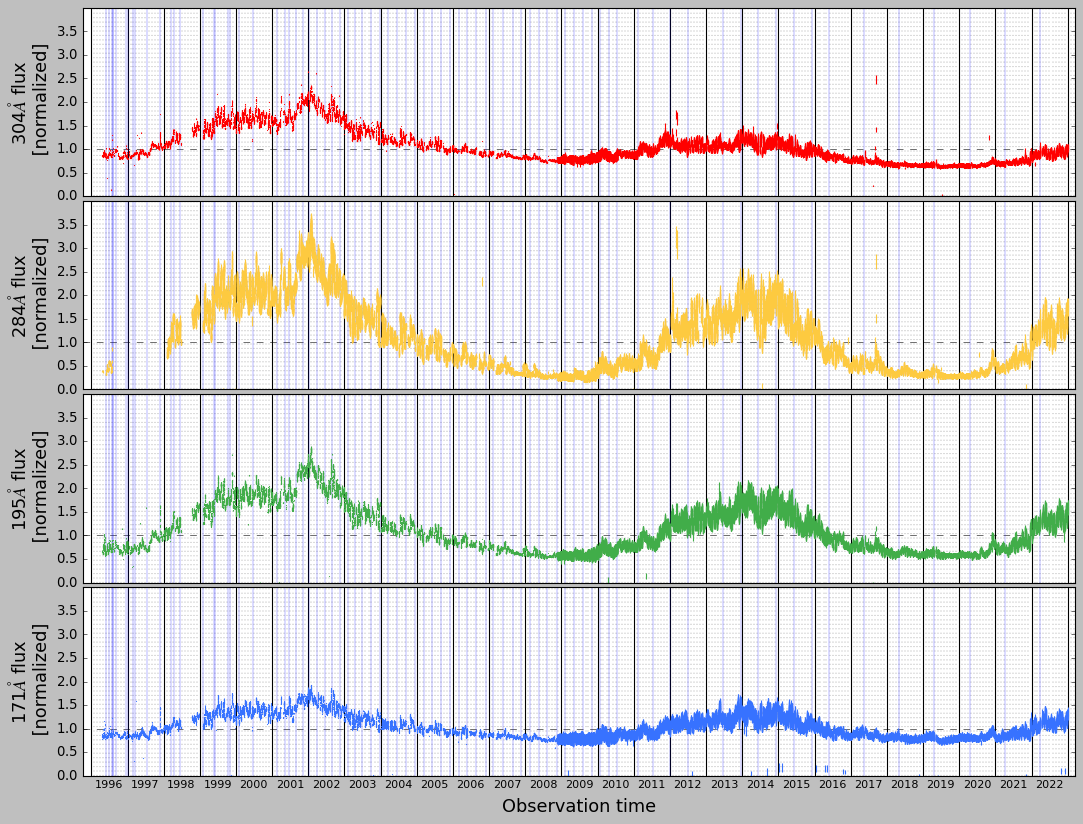

In [7]:
cs = ['r', '#fdca40', '#41ad49', '#3772ff']
ws = [304, 284, 195, 171]

fig, axes = plt.subplots(4,1,figsize=(16,12))

for i, y in enumerate(np.arange(1996,2023)):
    jan1_thisyear = '{0}-01-01T00:00:00.000Z'.format(str(y))
    jan1_thisyear = astropy.time.Time(jan1_thisyear).jd
    
    for ax in axes:
        ax.axvline(jan1_thisyear,color='k',ls='-',lw=1,zorder=1)  

        for m in range(2,13):
            m1 = str(y) + '-' + str(m).zfill(2) + '-01T00:00:00.000Z'
            m1 = astropy.time.Time(m1).jd
            ax.axvline(m1, color='k', ls=':', lw=0.25, zorder=1)
    axes[3].text(jan1_thisyear + 180., -0.25, str(y),horizontalalignment='center',fontsize=10,backgroundcolor='None')

jan1 = '2023-01-01T00:00:00.000Z'
jan1 = astropy.time.Time(jan1).jd
for ax in axes:
    ax.axvline(jan1, color='k', ls='-', lw=1)
    ax.axhline(1, color='k', ls = '--', lw=0.5, zorder=1)
    for m in range(2,4):
        m1 = str(2023) + '-' + str(m).zfill(2) + '-01T00:00:00.000Z'
        m1 = astropy.time.Time(m1).jd
        ax.axvline(m1, color='k', ls=':', lw=0.25, zorder=1)
    for i in range(81):
        bakeoutStartDate = heaterOn[i]['jd']
        bakeoutEndDate = heaterOff[i]['jd']

        ax.axvline(bakeoutStartDate,color='b',linestyle='-',lw=0.25)
        #ax.axvline(bakeoutEndDate,color='g',linestyle='-',lw=0.5)

    
for i, ax in enumerate(axes):
    result = results[i]
    ts = result['average_observation_time[JD]']
    fs = result['flux[DN/s]']
    us = result['flux_unc[DN/s]']

    fluxnorm = np.median(fs)

    plotcolor = cs[i]
    axes[i].errorbar(ts, fs/fluxnorm, yerr=us/fluxnorm, ls='None', elinewidth=1, capsize=0, marker='.',ms=2,c=plotcolor,ecolor=plotcolor,markeredgecolor='None')
    #axes[i].plot(ts, 0.3*np.ones_like(ts), marker='|',ms=20,mec=plotcolor,ls='None')
    #axes[i].set_ylabel(r"{0}$\AA$ flux,""\n"" ({1} obs)".format(ws[wmask][0],len(ts[wmask])))
    axes[i].set_ylabel(r"{0}$\AA$ flux""\n"" [normalized]".format(ws[i]), fontsize=16)
    axes[i].set_yticks([0.,0.5,1.0,1.5,2.0,2.5,3.0,3.5])

for ax in axes:
    ax.set_xticks([])

    ax.ticklabel_format(scilimits=(-4,4),useMathText=True)
    ax.set_ylim(0.,4.0)
    ax.set_xlim(2450000, 2460020)
    
    
    
#axes[0].set_title(r'Normalized EIT full sun LCs, full mission',fontsize=20)
'''
axes[0].set_ylim(0.,2.75)
axes[1].set_ylim(0.,4.)
axes[2].set_ylim(0.,3.0)
axes[3].set_ylim(0.,2.0)
'''
axes[3].set_xlabel('Observation time', fontsize=16,labelpad=20)
plt.subplots_adjust(hspace=0.025)
#plt.show()
plt.savefig("./EIT_LCs_fullmission.pdf", bbox_inches="tight")

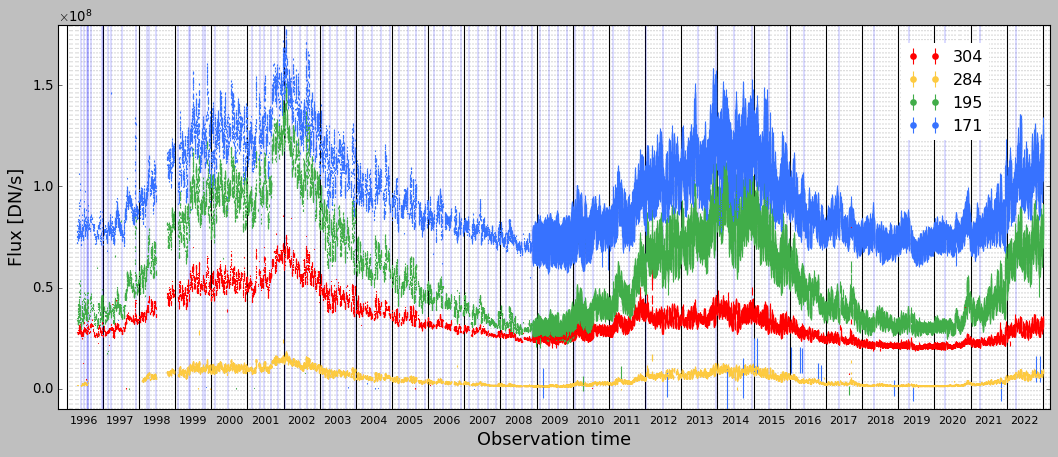

In [8]:
cs = ['r', '#fdca40', '#41ad49', '#3772ff']
ws = [304, 284, 195, 171]

fig, ax = plt.subplots(1,1,figsize=(16,6))

for i, y in enumerate(np.arange(1996,2023)):
    jan1_thisyear = '{0}-01-01T00:00:00.000Z'.format(str(y))
    jan1_thisyear = astropy.time.Time(jan1_thisyear).jd
    
    ax.axvline(jan1_thisyear,color='k',ls='-',lw=1,zorder=1)  

    for m in range(2,13):
        m1 = str(y) + '-' + str(m).zfill(2) + '-01T00:00:00.000Z'
        m1 = astropy.time.Time(m1).jd
        ax.axvline(m1, color='k', ls=':', lw=0.25, zorder=1)
    ax.text(jan1_thisyear + 180., -0.175e8, str(y),horizontalalignment='center',fontsize=10,backgroundcolor='None')

jan1 = '2023-01-01T00:00:00.000Z'
jan1 = astropy.time.Time(jan1).jd
ax.axvline(jan1, color='k', ls='-', lw=1)

for m in range(2,4):
    m1 = str(2023) + '-' + str(m).zfill(2) + '-01T00:00:00.000Z'
    m1 = astropy.time.Time(m1).jd
    ax.axvline(m1, color='k', ls=':', lw=0.25, zorder=1)

for i in range(81):
    bakeoutStartDate = heaterOn[i]['jd']
    bakeoutEndDate = heaterOff[i]['jd']

    ax.axvline(bakeoutStartDate,color='b',linestyle='-',lw=0.25)
    #ax.axvline(bakeoutEndDate,color='g',linestyle='-',lw=0.5)

for i in range(4):
    result = results[i]
    ts = result['average_observation_time[JD]']
    fs = result['flux[DN/s]']
    us = result['flux_unc[DN/s]']

    plotcolor = cs[i]
    ax.errorbar(ts, fs, yerr=us, ls='None', elinewidth=1, capsize=0, marker='.',ms=2,c=plotcolor, markeredgecolor='None',ecolor=plotcolor)
    ax.errorbar(-1000, 0., 1, marker='o',ls='None',elinewidth=1,capsize=0,c=plotcolor,label=ws[i],markeredgecolor='None',ecolor=plotcolor)

ax.set_ylabel(r"Flux [DN/s]", fontsize=16)
#ax.set_yticks([0.,0.5,1.0,1.5,2.0,2.5,3.0,3.5])

ax.set_xticks([])
ax.ticklabel_format(scilimits=(-4,4),useMathText=True)
ax.set_ylim(-0.1e8,1.8e8)
ax.set_xlim(2450000, 2460020)
   
ax.set_xlabel('Observation time', fontsize=16,labelpad=20)
plt.legend(loc=(0.85,0.7),edgecolor='None')
#plt.show()
plt.savefig("./EIT_LCs_fullmission_allsameplot_unnormalized.pdf", bbox_inches="tight")

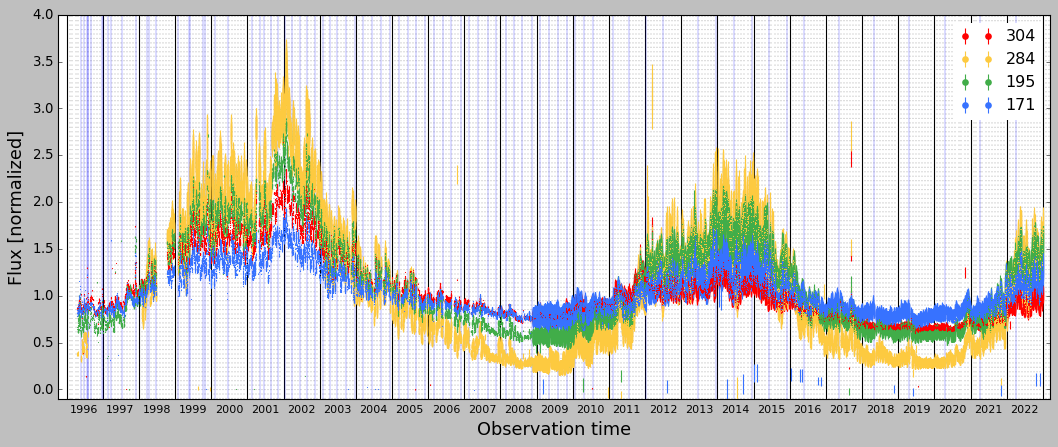

In [9]:
cs = ['r', '#fdca40', '#41ad49', '#3772ff']
ws = [304, 284, 195, 171]

fig, ax = plt.subplots(1,1,figsize=(16,6))

for i, y in enumerate(np.arange(1996,2023)):
    jan1_thisyear = '{0}-01-01T00:00:00.000Z'.format(str(y))
    jan1_thisyear = astropy.time.Time(jan1_thisyear).jd
    
    ax.axvline(jan1_thisyear,color='k',ls='-',lw=1,zorder=1)  

    for m in range(2,13):
        m1 = str(y) + '-' + str(m).zfill(2) + '-01T00:00:00.000Z'
        m1 = astropy.time.Time(m1).jd
        ax.axvline(m1, color='k', ls=':', lw=0.25, zorder=1)
    ax.text(jan1_thisyear + 180., -0.25, str(y),horizontalalignment='center',fontsize=10,backgroundcolor='None')

jan1 = '2023-01-01T00:00:00.000Z'
jan1 = astropy.time.Time(jan1).jd
ax.axvline(jan1, color='k', ls='-', lw=1)

for m in range(2,4):
    m1 = str(2023) + '-' + str(m).zfill(2) + '-01T00:00:00.000Z'
    m1 = astropy.time.Time(m1).jd
    ax.axvline(m1, color='k', ls=':', lw=0.25, zorder=1)
for i in range(81):
    bakeoutStartDate = heaterOn[i]['jd']
    bakeoutEndDate = heaterOff[i]['jd']

    ax.axvline(bakeoutStartDate,color='b',linestyle='-',lw=0.25)
    #ax.axvline(bakeoutEndDate,color='g',linestyle='-',lw=0.5)
    
for i in range(4):
    result = results[i]
    ts = result['average_observation_time[JD]']
    fs = result['flux[DN/s]']
    us = result['flux_unc[DN/s]']

    fluxnorm = np.median(fs)

    plotcolor = cs[i]
    ax.errorbar(ts, fs/fluxnorm, yerr=us/fluxnorm, ls='None', elinewidth=1, capsize=0, marker='.',ms=2,c=plotcolor,ecolor=plotcolor,markeredgecolor='None')
    ax.errorbar(-1000, 0., 1, marker='o',ls='None',elinewidth=1,capsize=0,c=plotcolor,label=ws[i],ecolor=plotcolor,markeredgecolor='None')

ax.set_ylabel(r"Flux [normalized]", fontsize=16)
#ax.set_yticks([0.,0.5,1.0,1.5,2.0,2.5,3.0,3.5])


ax.set_xticks([])
ax.ticklabel_format(scilimits=(-4,4),useMathText=True)
ax.set_ylim(-0.1,4.)
ax.set_xlim(2450000, 2460020)
   
ax.set_xlabel('Observation time', fontsize=16,labelpad=20)
plt.legend(loc='upper right',edgecolor='None')
#plt.show()
plt.savefig("./EIT_LCs_fullmission_allsameplot_normalized.pdf", bbox_inches="tight")

/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_63510/790524599.py:23: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0.,3.5)


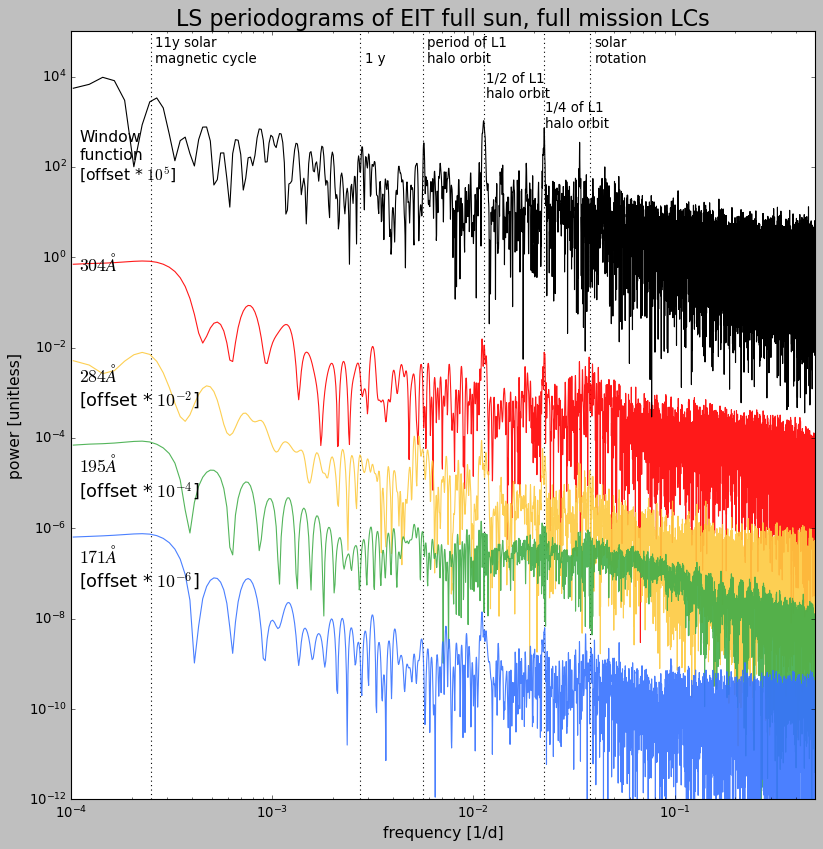

In [10]:
cs = ['r', '#fdca40', '#41ad49', '#3772ff']
fig, ax = plt.subplots(1,1,figsize=(12,12))

for i in range(4):
    result = results[i]
    ts = result['average_observation_time[JD]']
    fs = result['flux[DN/s]']
    us = result['flux_unc[DN/s]']

    fluxnorm = np.median(fs)

    freq, pow = LombScargle(ts,fs,us).autopower(minimum_frequency=(1./np.ptp(ts)), maximum_frequency=(1./2.))

    plotcolor = cs[i]
    ax.plot(freq,pow*10**-(2*i),ls='-',color=plotcolor,alpha=0.9)

wfreq, wpow = LombScargle(ts,np.ones_like(fs)).autopower(minimum_frequency=(1./np.ptp(ts)), maximum_frequency=(1./2.))
ax.plot(wfreq,wpow*10**5,ls='-',color='k',alpha=1)

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_ylim(0.,3.5)

ax.axvline(1./26.24,color='k',ls=':',zorder=1)     #solar rotation
ax.axvline(1./178., color='k',ls=':',zorder=1)     #period of L1 halo orbit, ~6 months
ax.axvline(2./178., color='k',ls=':',zorder=1)     #1/2 period of L1 halo orbit, ~3 months
ax.axvline(4./178., color='k',ls=':',zorder=1)     #1/4 period of L1 halo orbit, ~1.5 months
ax.axvline(1./365.,color='k',ls=':',zorder=1)      #1 year
ax.axvline(1./(11*365.),color='k',ls=':',zorder=1) #magnetic cycle
    
ax.text(1.05/26.24, 2.e4, 'solar'+'\n'+'rotation',fontsize=12)
ax.text(1.05/178., 2.e4, 'period of L1'+'\n'+'halo orbit',fontsize=12)
ax.text(1.05/365., 2.e4, '1 y',fontsize=12)
ax.text(2.05/178., 3.3e3, '1/2 of L1'+'\n'+'halo orbit',fontsize=12,color='k')
ax.text(4.05/178., 0.75e3, '1/4 of L1'+'\n'+'halo orbit',fontsize=12,color='k')
ax.text(1.05/(365*11), 2.e4, '11y solar'+'\n'+'magnetic cycle',fontsize=12)


ax.text(1.1e-4, 5*10**(1), r'Window'+'\n'+'function'+'\n'+r'[offset * $10^{5}$]',fontsize=14)
ax.text(1.1e-4, 5.e-1, r'$304\AA$',fontsize=16)
ax.text(1.1e-4, 5.e-4, r'$284\AA$'+'\n'+r'[offset * $10^{-2}$]',fontsize=16)
ax.text(1.1e-4, 5.e-6, r'$195\AA$'+'\n'+r'[offset * $10^{-4}$]',fontsize=16)
ax.text(1.1e-4, 5.e-8, r'$171\AA$'+'\n'+r'[offset * $10^{-6}$]',fontsize=16)

ax.set_ylim(1.e-12,10**(5))
ax.set_xlim(1.e-4,0.5)
ax.set_xlabel("frequency [1/d]", fontsize=14)
ax.set_ylabel("power [unitless]", fontsize=14)

ax.set_title(r'LS periodograms of EIT full sun, full mission LCs',fontsize=20)
#plt.show()
plt.savefig("./EIT_periodograms_fullmission.pdf", bbox_inches="tight")

<>:39: SyntaxWarning: invalid escape sequence '\A'
<>:39: SyntaxWarning: invalid escape sequence '\A'
/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_63510/4020286965.py:39: SyntaxWarning: invalid escape sequence '\A'
  '''
/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_63510/4020286965.py:23: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0.,3.5)


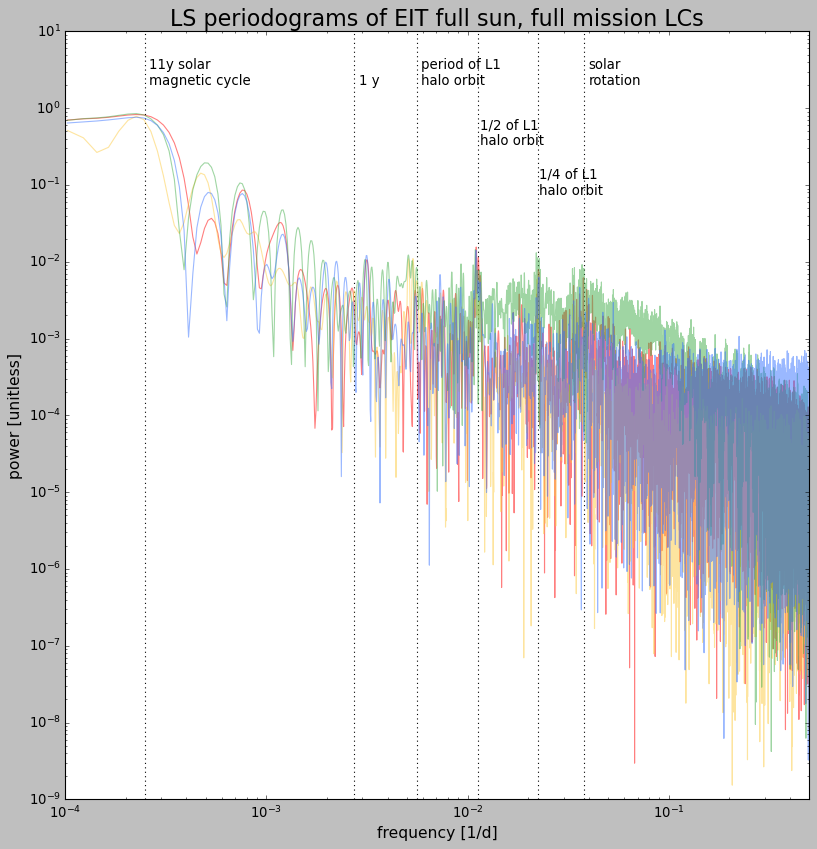

In [11]:
cs = ['r', '#fdca40', '#41ad49', '#3772ff']
fig, ax = plt.subplots(1,1,figsize=(12,12))
wfreq, wpow = LombScargle(ts,np.ones_like(fs)).autopower(minimum_frequency=(1./np.ptp(ts)), maximum_frequency=(1./2.))
#ax.plot(wfreq,wpow,ls='-',color='k',alpha=1)

for i in range(4):
    result = results[i]
    ts = result['average_observation_time[JD]']
    fs = result['flux[DN/s]']
    us = result['flux_unc[DN/s]']

    fluxnorm = np.median(fs)

    freq, pow = LombScargle(ts,fs,us).autopower(minimum_frequency=(1./np.ptp(ts)), maximum_frequency=(1./2.))

    plotcolor = cs[i]
    ax.plot(freq,pow,ls='-',color=plotcolor,alpha=0.5)


ax.set_xscale("log")
ax.set_yscale("log")

ax.set_ylim(0.,3.5)

ax.axvline(1./26.24,color='k',ls=':',zorder=1)     #solar rotation
ax.axvline(1./178., color='k',ls=':',zorder=1)     #period of L1 halo orbit, ~6 months
ax.axvline(2./178., color='k',ls=':',zorder=1)     #1/2 period of L1 halo orbit, ~3 months
ax.axvline(4./178., color='k',ls=':',zorder=1)     #1/4 period of L1 halo orbit, ~1.5 months
ax.axvline(1./365.,color='k',ls=':',zorder=1)      #1 year
ax.axvline(1./(11*365.),color='k',ls=':',zorder=1) #magnetic cycle
    
ax.text(1.05/26.24, 2.e0, 'solar'+'\n'+'rotation',fontsize=12)
ax.text(1.05/178., 2.e0, 'period of L1'+'\n'+'halo orbit',fontsize=12)
ax.text(1.05/365., 2.e0, '1 y',fontsize=12)
ax.text(2.05/178., 3.3e-1, '1/2 of L1'+'\n'+'halo orbit',fontsize=12,color='k')
ax.text(4.05/178., 0.75e-1, '1/4 of L1'+'\n'+'halo orbit',fontsize=12,color='k')
ax.text(1.05/(365*11), 2.e0, '11y solar'+'\n'+'magnetic cycle',fontsize=12)

'''
ax.text(1.1e-4, 5*10**(1), r'Window'+'\n'+'function'+'\n'+r'[offset * $10^{5}$]',fontsize=14)
ax.text(1.1e-4, 5.e-1, r'$304\AA$',fontsize=16)
ax.text(1.1e-4, 5.e-4, r'$284\AA$'+'\n'+r'[offset * $10^{-2}$]',fontsize=16)
ax.text(1.1e-4, 5.e-6, r'$195\AA$'+'\n'+r'[offset * $10^{-4}$]',fontsize=16)
ax.text(1.1e-4, 5.e-8, r'$171\AA$'+'\n'+r'[offset * $10^{-6}$]',fontsize=16)
'''
ax.set_ylim(1.e-9,10**(1))
ax.set_xlim(1.e-4,0.5)
ax.set_xlabel("frequency [1/d]", fontsize=14)
ax.set_ylabel("power [unitless]", fontsize=14)

ax.set_title(r'LS periodograms of EIT full sun, full mission LCs',fontsize=20)
#plt.show()
plt.savefig("./EIT_periodograms_fullmission_samesubplot.pdf", bbox_inches="tight")

In [12]:
# corner plot showing other solar missions
# normalized by heliocentric distance
SEM = Table.read("./CELIAS-SEM/SEMDailyData_norm.txt",format="ascii")
SEM = SEM[SEM['t_obs[JD]'] >= 2450190.]
print(SEM.colnames)

# from header:
# "Irradiances are reported at a mean solar distance of 1 AU and zero
#; relative line-of-sight velocity with respect to the Sun."
# so already normalized by heliocentric distance.
SORCE = Table.read("./SORCE/SORCEfluxTransmittedThroughEITFilters.txt", format="ascii")
print(SORCE.colnames)
print(SORCE['date[JD]'][0])
print(SORCE['date[JD]'][-1])

VIRGO = Table.read("./VIRGO/virgoDailyData.txt",format="ascii")
VIRGO = VIRGO[VIRGO['t_obs[JD]'] >= 2450190.]
print(VIRGO)

['t_obs[JD]', 'firstOrderFlux[counts/s]', 'firstOrderFluxUnc[counts/s]', 'centralOrderFlux[counts/s]', 'centralOrderFluxUnc[counts/s]']
['date[JD]', 'transmitted_flux_171[arb.units]', 'transmitted_flux_171_unc[arb.units]', 'transmitted_flux_195[arb.units]', 'transmitted_flux_195_unc[arb.units]', 'transmitted_flux_284[arb.units]', 'transmitted_flux_284_unc[arb.units]', 'transmitted_flux_304[arb.units]', 'transmitted_flux_304_unc[arb.units]', 'transmitted_flux_sumEITBands[arb.units]', 'transmitted_flux_sumEITBands_unc[arb.units]']
2452696.0
2458904.0
t_obs[JD] flux[W/m^2] flux_unc[W/m^2]
--------- ----------- ---------------
2450190.0    1360.378           0.131
2450191.0    1360.407           0.136
2450192.0    1360.431           0.131
2450193.0    1360.428           0.136
2450194.0    1360.405           0.134
2450195.0    1360.382           0.133
2450196.0    1360.361           0.136
2450197.0    1360.343           0.132
2450198.0    1360.372           0.137
2450199.0    1360.388      

In [66]:
def medianBinNormalize(tDaily, tEIT, fEIT, uEIT):
    '''
    median-bin the flux from one EIT band into daily values
    '''
    binned_f, bin_edges, binnumber = binned_statistic(x=tEIT, values=fEIT, statistic='median', bins=tDaily)
    binned_u, bin_edges, binnumber = binned_statistic(x=tEIT, values=uEIT, statistic='mean', bins=tDaily)
    binned_u = np.sqrt((np.pi/2)*binned_u)
    med = np.median(binned_f[~np.isnan(binned_f)])
    return binned_f/med, binned_u/med


In [67]:
tDaily = np.arange(np.min(SEM['t_obs[JD]']), np.max(SEM['t_obs[JD]']),1)
print(tDaily)

bf_virgo, bu_virgo = medianBinNormalize(tDaily, VIRGO['t_obs[JD]'],VIRGO['flux[W/m^2]'], VIRGO['flux_unc[W/m^2]'])
bf_SEM1, bu_SEM1 = medianBinNormalize(tDaily, SEM['t_obs[JD]'], SEM['firstOrderFlux[counts/s]'], SEM['firstOrderFluxUnc[counts/s]'])
bf_SEM0, bu_SEM0 = medianBinNormalize(tDaily, SEM['t_obs[JD]'], SEM['centralOrderFlux[counts/s]'], SEM['centralOrderFluxUnc[counts/s]'])
bf_SORCE, bu_SORCE = medianBinNormalize(tDaily, SORCE['date[JD]'], SORCE['transmitted_flux_sumEITBands[arb.units]'], SORCE['transmitted_flux_sumEITBands_unc[arb.units]'])

bf_304, bu_304 = medianBinNormalize(tDaily, results[0]['average_observation_time[JD]'], results[0]['flux[DN/s]'], results[0]['flux_unc[DN/s]'])
bf_284, bu_284 = medianBinNormalize(tDaily, results[1]['average_observation_time[JD]'], results[1]['flux[DN/s]'], results[1]['flux_unc[DN/s]'])
bf_195, bu_195 = medianBinNormalize(tDaily, results[2]['average_observation_time[JD]'], results[2]['flux[DN/s]'], results[2]['flux_unc[DN/s]'])
bf_171, bu_171 = medianBinNormalize(tDaily, results[3]['average_observation_time[JD]'], results[3]['flux[DN/s]'], results[3]['flux_unc[DN/s]'])
tDaily = 0.5*(tDaily[1:] + tDaily[0:-1])

[2450190. 2450191. 2450192. ... 2460346. 2460347. 2460348.]


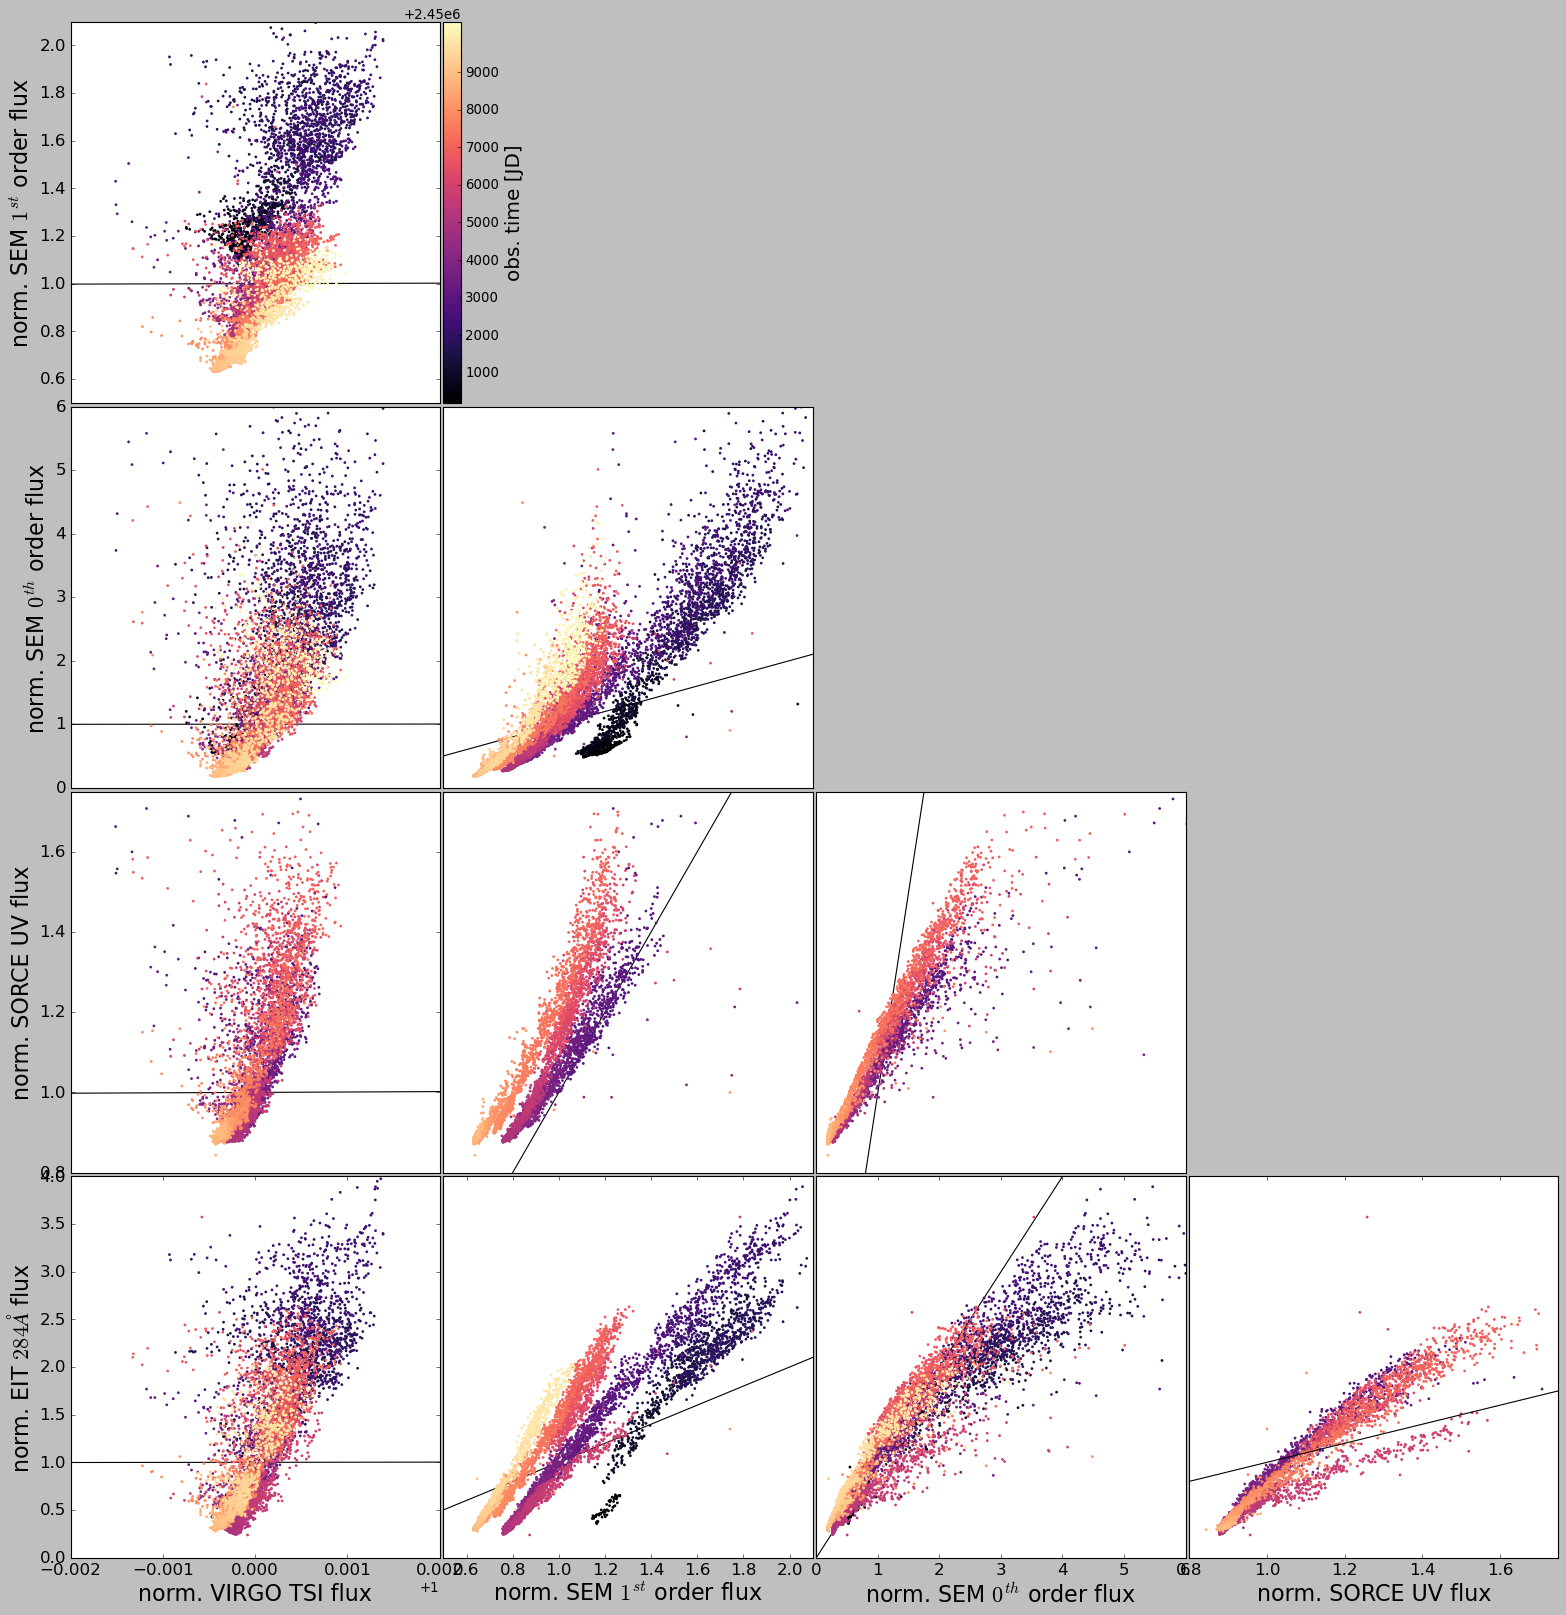

In [122]:
fig, axes = plt.subplots(4,4,figsize=(24,24))

bf_EIT = bf_284

divider00 = make_axes_locatable(axes[0,1])
cax00 = divider00.append_axes('left',size='5%', pad=0)
c_s = axes[0,0].scatter(bf_virgo, bf_SEM1,c=tDaily,marker='.',s=25, edgecolor='None', cmap='magma',vmin=np.min(tDaily),vmax=np.max(tDaily),zorder=2)
cbar = fig.colorbar(c_s, cax=cax00, orientation='vertical',)
cbar.ax.set_yticks(np.arange(2451000,2460000,1000))
cbar.set_label(label='obs. time [JD]',fontsize=18)

axes[1,0].scatter(bf_virgo, bf_SEM0,c=tDaily,marker='.',s=25, edgecolor='None', cmap='magma',vmin=np.min(tDaily),vmax=np.max(tDaily),zorder=2)
axes[2,0].scatter(bf_virgo, bf_SORCE,c=tDaily,marker='.',s=25, edgecolor='None', cmap='magma',vmin=np.min(tDaily),vmax=np.max(tDaily),zorder=2)
axes[3,0].scatter(bf_virgo, bf_EIT,c=tDaily,marker='.',s=25, edgecolor='None', cmap='magma',vmin=np.min(tDaily),vmax=np.max(tDaily),zorder=2)

axes[0,1].axis('off')
axes[1,1].scatter(bf_SEM1, bf_SEM0,c=tDaily,marker='.',s=25, edgecolor='None', cmap='magma',vmin=np.min(tDaily),vmax=np.max(tDaily),zorder=2)
axes[2,1].scatter(bf_SEM1, bf_SORCE,c=tDaily,marker='.',s=25, edgecolor='None', cmap='magma',vmin=np.min(tDaily),vmax=np.max(tDaily),zorder=2)
axes[3,1].scatter(bf_SEM1, bf_EIT,c=tDaily,marker='.',s=25, edgecolor='None', cmap='magma',vmin=np.min(tDaily),vmax=np.max(tDaily),zorder=2)

axes[0,2].axis('off')
axes[1,2].axis('off')
axes[2,2].scatter(bf_SEM0, bf_SORCE,c=tDaily,marker='.',s=25, edgecolor='None', cmap='magma',vmin=np.min(tDaily),vmax=np.max(tDaily),zorder=2)
axes[3,2].scatter(bf_SEM0, bf_EIT,c=tDaily,marker='.',s=25, edgecolor='None', cmap='magma',vmin=np.min(tDaily),vmax=np.max(tDaily),zorder=2)

axes[0,3].axis('off')
axes[1,3].axis('off')
axes[2,3].axis('off')
axes[3,3].scatter(bf_SORCE, bf_EIT,c=tDaily,marker='.',s=25, edgecolor='None', cmap='magma',vmin=np.min(tDaily),vmax=np.max(tDaily))

for ax in axes[:,0]:
    ax.set_xlim(1.-0.002, 1.+0.002)

for ax in axes[:,1]:
    ax.set_xlim(0.5,2.1)

for ax in axes[:,2]:
    ax.set_xlim(0.,6)

for ax in axes[:,3]:
    ax.set_xlim(0.8,1.75)

for ax in axes[0]:
    ax.set_ylim(0.5,2.1)

for ax in axes[1]:
    ax.set_ylim(0.,6)

for ax in axes[2]:
    ax.set_ylim(0.8,1.75)

for ax in axes[3]:
    #ax.set_ylim(0.5,2.5)
    ax.set_ylim(0.,4)

axes[0,0].set_xticks([])
axes[1,0].set_xticks([])
axes[2,0].set_xticks([])
axes[1,1].set_xticks([])
axes[2,1].set_xticks([])
axes[2,2].set_xticks([])

axes[1,1].set_yticks([])
axes[2,1].set_yticks([])
axes[3,1].set_yticks([])
axes[2,2].set_yticks([])
axes[3,2].set_yticks([])
axes[3,3].set_yticks([])

axes[0,0].set_ylabel(r"norm. SEM $1^{st}$ order flux",fontsize=20)
axes[1,0].set_ylabel(r"norm. SEM $0^{th}$ order flux",fontsize=20)
axes[2,0].set_ylabel(r"norm. SORCE UV flux",fontsize=20)
axes[3,0].set_ylabel(r"norm. EIT $284\AA$ flux",fontsize=20)

axes[3,0].set_xlabel(r"norm. VIRGO TSI flux",fontsize=20)
axes[3,1].set_xlabel(r"norm. SEM $1^{st}$ order flux",fontsize=20)
axes[3,2].set_xlabel(r"norm. SEM $0^{th}$ order flux",fontsize=20)
axes[3,3].set_xlabel(r"norm. SORCE UV flux",fontsize=20)
x = np.arange(10)
for ax in [axes[0,0],axes[1,0],axes[2,0],axes[3,0],axes[1,1],axes[2,1],axes[3,1],axes[2,2],axes[3,2],axes[3,3]]:
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.plot(x,x,'k-',zorder=1)
plt.subplots_adjust(hspace=0.01,wspace=0.01)
#plt.show()
plt.savefig("allInstrumentComparison.pdf",bbox_inches='tight')